In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq espiownage fastai wwf # upgrade fastai on colab

# Segmentation: *Inference* on Other Musical Instruments
> New images never seen by the model, different antinode shapes, etc...

A neat result of our work is that *even though the segmentation-regression model was only trained on ellipses*, **it is able to fit other antinode shapes and count interference fringes on non-steelpans when running purely in "inference mode"!**  Below we show some examples of when this goes well and when it does not.

In [ ]:
#all_slow

In [ ]:
!pip install -Uqq espiownage

# Libraries

In [ ]:
from fastai.vision.all import *
from espiownage.core import *

let's just get clear from the start which model we want:

In [ ]:
model_to_load = 'seg_reg_full_real_2' # .pth'

imgdir = '/home/sstudent/datasets/other_espi_instruments/resized'

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish   # MishJIT gives me trouble :-( 
from fastai.losses import BaseLoss, MSELossFlat, CrossEntropyLossFlat, BCEWithLogitsLossFlat
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import aug_transforms
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np
import random

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

import glob
from pathlib import Path

In [ ]:
path = Path('/home/sstudent/datasets/espiownage-cleaner/')  # real data is local and private 
bin_size = 0.7  
maskdir = path / ('masks_'+str(bin_size))
path_im = path/'images'
path_lbl = path/maskdir
meta_names = sorted(glob.glob(str(path/'annotations')+'/*.csv'))
fnames = [meta_to_img_path(x, img_bank=path_im) for x in meta_names]
random.shuffle(fnames)
lbl_names = get_image_files(path_lbl)
get_msk = lambda o: path/maskdir/f'{o.stem}_P{o.suffix}'
colors = list(range(int(11/bin_size) + 1))
codes = [str(n) for n in range(len(colors))]; codes
sz = (384,512)
db = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=get_msk,
    batch_tfms=[*aug_transforms(size=sz, flip_vert=True), Normalize.from_stats(*imagenet_stats)])
    
dls = db.dataloaders(path/'images', fnames=fnames, bs=16)  # if OOM occurs lower bs to as low as 2
dls.vocab = codes

/home/sstudent/.local/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/sstudent/.local/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.

# First: Segmentation-Regression: Detecting antinodes & counting rings
on new, never-before seen images of totally new instruments!  Let's see how the trained model does...

In [ ]:
opt = ranger 
hrfac = 1.2  # 'headroom factor'
codes = [str(n) for n in range(16)]; codes
y_range=(0,int(len(codes)*hrfac))  # balance between "clamping" to range of real data vs too much "compression" from sigmoid nonlineari
learn = unet_learner(dls, resnet34, n_out=1, y_range=y_range, loss_func=MSELossFlat(), self_attention=True, act_cls=Mish, opt_func=opt)
learn.load('seg_reg_full_real_2')

/home/sstudent/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
from PIL import ImageOps 

def save_tmask(tmask, fname='', norm=False, purple=False, blend_img=None): # save tensor mask
    tmask_new = tmask[0].squeeze().cpu().numpy() 
    use_min, use_max = 0, np.max(np.array(colors))    # use scale of max ring count
    if norm: use_min, use_max = tmask_new.min(), tmask_new.max()   # auto scale for just this image
    rescaled = (255.0 / use_max * (tmask_new - use_min)).astype(np.uint8)
    im = Image.fromarray(rescaled)
    if purple: im = ImageOps.colorize(im, black ="black", white =(255,0,255))
    if blend_img is not None: im = Image.blend(blend_img, im, 0.4)
    if fname != '': im.save(fname)
    return im

### Seg-Reg on New Images

In [ ]:
#pfnames = sorted(glob.glob(imgdir+'/*'))
#print(pfnames)
#print(pfnames[0],pfnames[5])
#print(len(pfnames))

Actually, there's a particular order I want to use, because I know how this turns out. So I'm going to specify:


In [ ]:
good_fnames = ['/home/sstudent/datasets/other_espi_instruments/resized/'+x  
           for x in ['musical_espi_moore_resized.jpg','musical_espi_wikipedia_resized.jpeg','lute1_resized.png',
                    'musical_espi_zooniverse_steelpan_resized.jpeg','musical_espi_guitar1.png']]

good_images = []
for f in good_fnames:
    good_images.append(PILImage.create(f))

In [ ]:
def my_get_preds(fnames, learn=None):
    dlpred = dls.test_dl(fnames)
    preds, _ = learn.get_preds(dl=dlpred)
    print(preds.shape)
    preds = preds.squeeze(1)
    print(preds.shape) # after squeezing
    return preds

preds = my_get_preds(good_images, learn=learn)

torch.Size([5, 1, 384, 512])
torch.Size([5, 384, 512])


In [ ]:
def show_inp_segreg(inp, segreg, vmax=3, bin_size=0.7):
    fig, axarr = plt.subplots(1,2, figsize=(12,4))
    axarr[0].imshow(inp)
    im = axarr[1].imshow(segreg.cpu().numpy()*bin_size, vmin=0, vmax=vmax)
    plt.colorbar(im, ax=axarr[1])
    plt.show()

What you're about to see is that for close-up, grainy images, the seg-reg method does a fairly reasonable job:

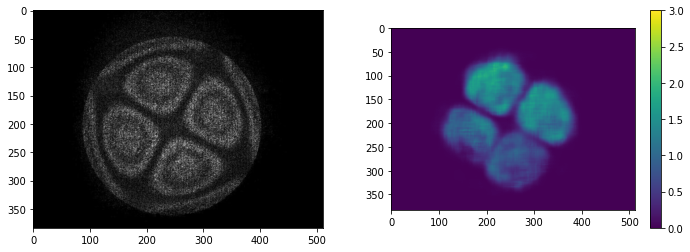

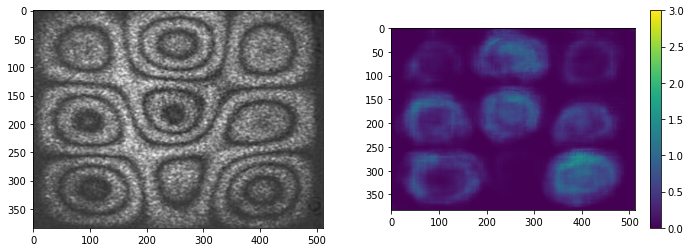

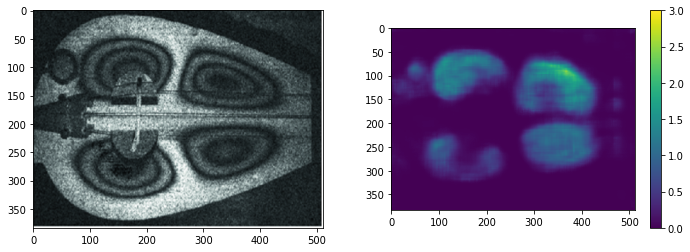

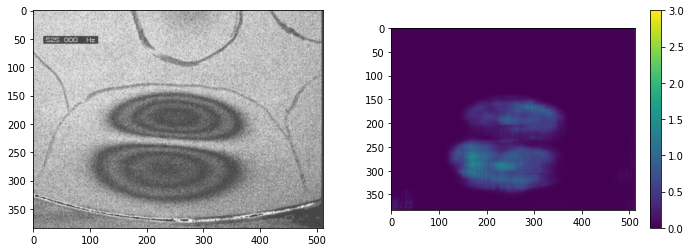

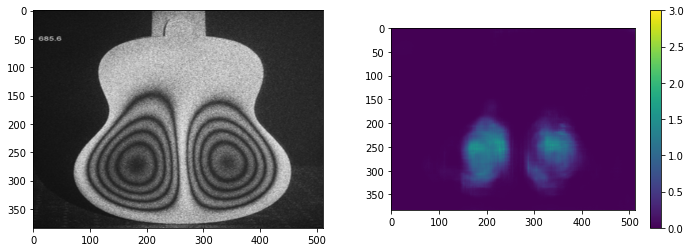

In [ ]:
for i in range(preds.shape[0]):
    show_inp_segreg(good_images[i], preds[i])

But for images that are taken from futher away, or composite images with white-space borders (pulled straight from JASA Twitter!), or even just really 'clean'-looking laser holography images, it barely detects anything at all.  ...For the composites and "small antinodes" in the images, it's because the model wasn't trained on it.  For the holography image of the guitar below -- we don't know yet!

Here are some "harder images" that the seg-reg model doesn't do well on:

torch.Size([5, 1, 384, 512])
torch.Size([5, 384, 512])


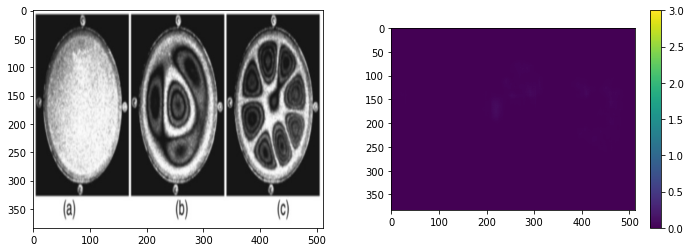

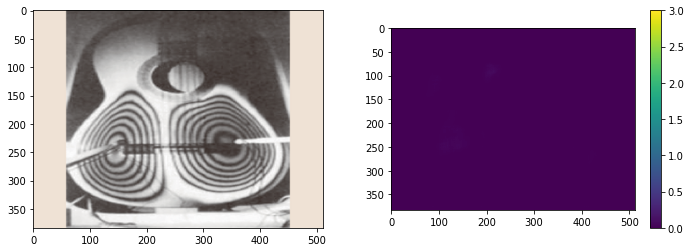

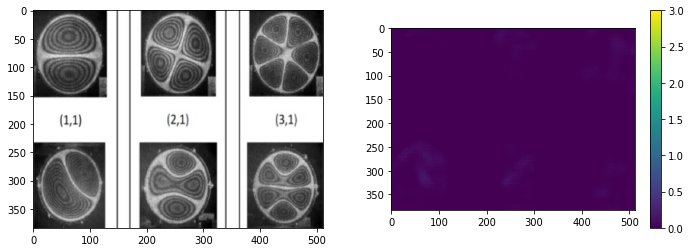

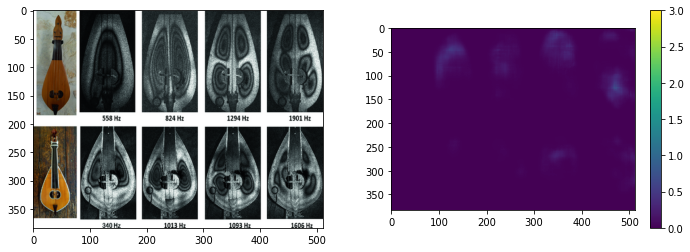

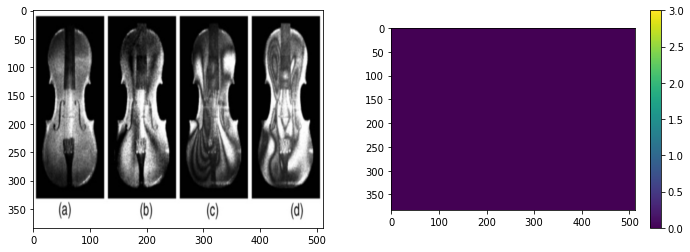

In [ ]:
harder_files, harder_imgs = [], []
for f in sorted(glob.glob(imgdir+'/*')):
    if f not in good_fnames: 
        harder_files.append(f)
        harder_imgs.append(PILImage.create(f))
        
preds = my_get_preds(harder_files, learn=learn)
        
for i in range(preds.shape[0]):
    show_inp_segreg(harder_imgs[i], preds[i])

# Second: "All-One-Class" Segmentation Detection of Antinode Regions
This is a less ambitious goal than the above, and works pretty well. This builds off the `seg_allone_real.ipynb` notebook. 

In [ ]:
checkpoint_file = 'seg_allone_full_real'

In [ ]:
# copy all this from the all-one-class training examples

path = Path('/home/sstudent/datasets/espiownage-cleaner/')
path_im = path/'images'
path_lbl = path/'masks'
#path = untar_data('https://anonymized.machine.com/~sstudent/espiownage-cleaner.tgz')
meta_names = sorted(glob.glob(str(path/'annotations')+'/*.csv'))
fnames = [meta_to_img_path(x, img_bank=path_im) for x in meta_names]
lbl_names = get_image_files(path_lbl)

get_msk = lambda o: path/'masks'/f'{o.stem}_P{o.suffix}'
colors = [0, 1]
codes = [str(n) for n in colors]; codes
sz = (384, 512)
name2id = {v:int(v) for k,v in enumerate(codes)}
void_code = name2id['0']

seg_db = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=get_msk,
                   batch_tfms=[*aug_transforms(size=sz, flip_vert=True), Normalize.from_stats(*imagenet_stats)])

dls = seg_db.dataloaders(path/"images", fnames=fnames, bs=2)

In [ ]:
opt=ranger
learn = unet_learner(dls, resnet34, self_attention=True, act_cls=Mish, opt_func=opt)
learn.load(checkpoint_file)

Yay! We're in business.   First let's try the good images:

In [ ]:
preds = my_get_preds(good_images, learn=learn)
preds.shape

torch.Size([5, 2, 384, 512])
torch.Size([5, 2, 384, 512])


torch.Size([5, 2, 384, 512])

In [ ]:
preds = preds.argmax(axis=1)
preds.shape

torch.Size([5, 384, 512])

In [ ]:
def show_inp_alloneseg(inp, seg, vmax=3, bin_size=0.7, colorbar=False):
    fig, axarr = plt.subplots(1,2, figsize=(12,4))
    axarr[0].imshow(inp)
    im = axarr[1].imshow(seg.cpu().numpy())
    if colorbar: plt.colorbar(im, ax=axarr[1])
    plt.show()

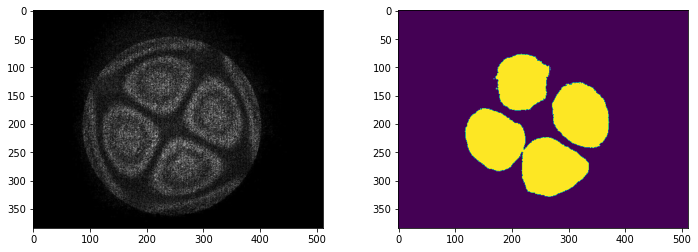

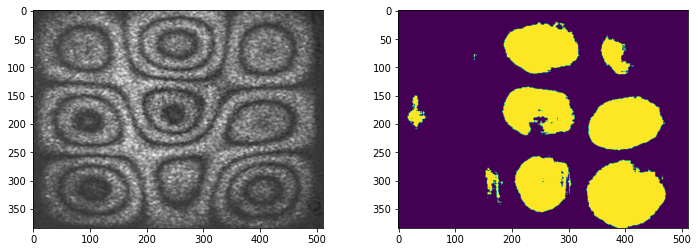

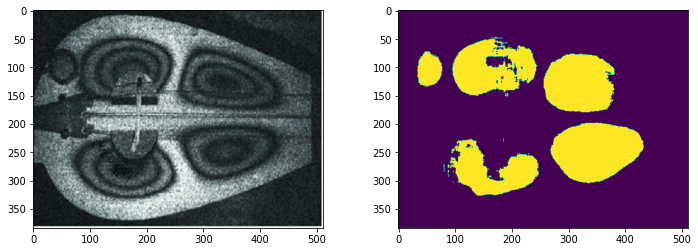

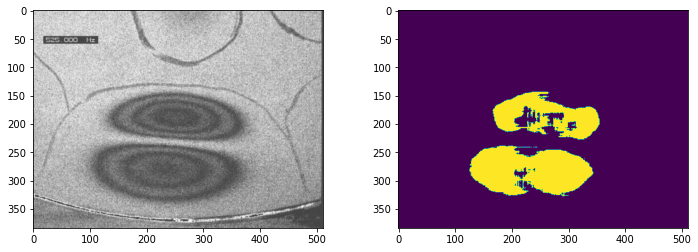

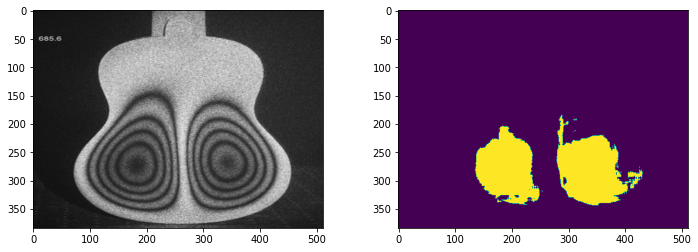

In [ ]:
for i in range(preds.shape[0]):
    show_inp_alloneseg(good_images[i], preds[i])

Now for the harder images:

Maybe we could go back and crop those images to zoom in on the antinodes better. Not sure right now.  We'll keep trying. 

torch.Size([5, 2, 384, 512])
torch.Size([5, 2, 384, 512])


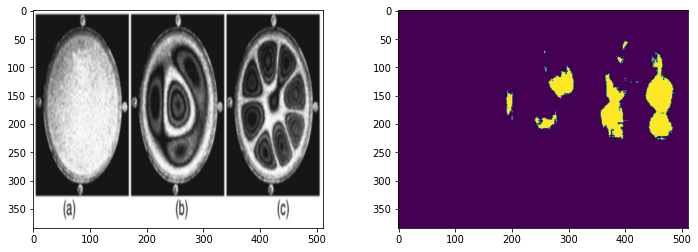

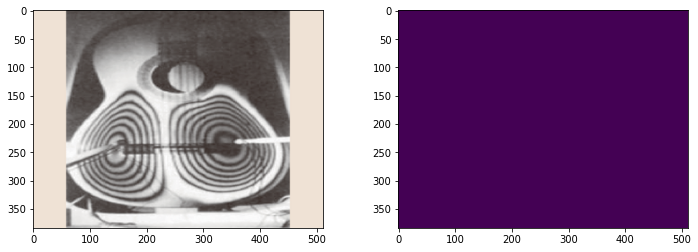

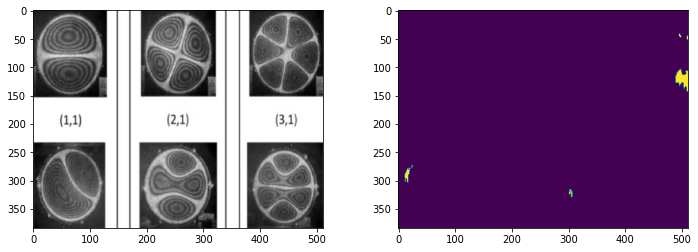

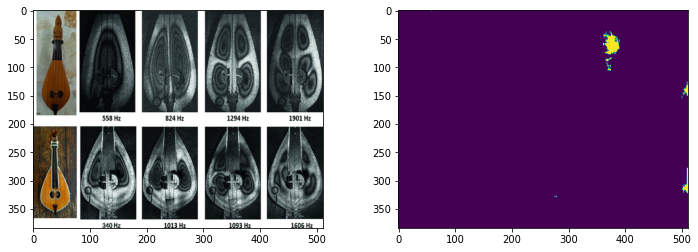

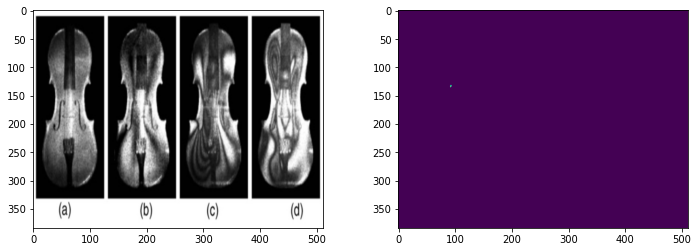

In [ ]:
preds = my_get_preds(harder_imgs, learn=learn)
preds = preds.argmax(axis=1)

for i in range(preds.shape[0]):
    show_inp_alloneseg(harder_imgs[i], preds[i])

# Concluding Remarks
It's not inconceivable that with a little Transfer Learning from our model(s) using a small training set of annotations for a new instrument, that it could learn to annotate and count rings in these other systems.
We would like to explore this in the future and see other enthusiast-researchers try to do the same.  Let us know how it goes! Perhaps together we can build a more general model-tool for doing inference all all sorts of ESPI (and even holography?) images...

*TODO: Add citation/copyright info for images*